In [ ]:
# !pip uninstall -y kaggle
# !pip install --upgrade pip
# !pip install kaggle==1.5.6

In [ ]:
mkdir -p ~/.kaggle

In [ ]:
'Bangalore'[::-1]

'erolagnaB'

In [ ]:
cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c cassava-leaf-disease-classification

100% 5.75G/5.76G [02:05<00:00, 27.9MB/s]
100% 5.76G/5.76G [02:05<00:00, 49.2MB/s]


In [ ]:
# !unzip cassava-leaf-disease-classification.zip

In [ ]:
ls

cassava-leaf-disease-classification.zip  test_images/
kaggle.json                              test_tfrecords/
label_num_to_disease_map.json            train.csv
sample_data/                             train_images/
sample_submission.csv                    train_tfrecords/


In [ ]:
import matplotlib.pylab as plt
import os
import pandas as pd
import tensorflow as tf 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D,AveragePooling2D, Input, Dense, Flatten, Dropout,BatchNormalization,ReLU
from tensorflow.keras.models import Model
import numpy as np
import cv2

In [ ]:
train = pd.read_csv('train.csv')
train = train.astype('str')
train.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [ ]:
train['label'].value_counts(normalize=True)

3    0.614946
4    0.120437
2    0.111511
1    0.102304
0    0.050802
Name: label, dtype: float64

In [ ]:
cv2.imread('train_images/1000201771.jpg').shape

(600, 800, 3)

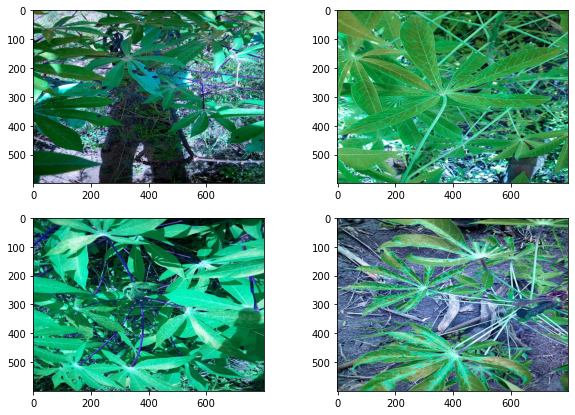

In [ ]:
# plt.figure(figsize=(10,7))
f, axarr = plt.subplots(2,2,figsize=(10, 7))
axarr[0,0].imshow(cv2.imread('train_images/1000015157.jpg'))
axarr[0,1].imshow(cv2.imread('train_images/1000723321.jpg'))
axarr[1,0].imshow(cv2.imread('train_images/999998473.jpg'))
axarr[1,1].imshow(cv2.imread('train_images/1000201771.jpg'))

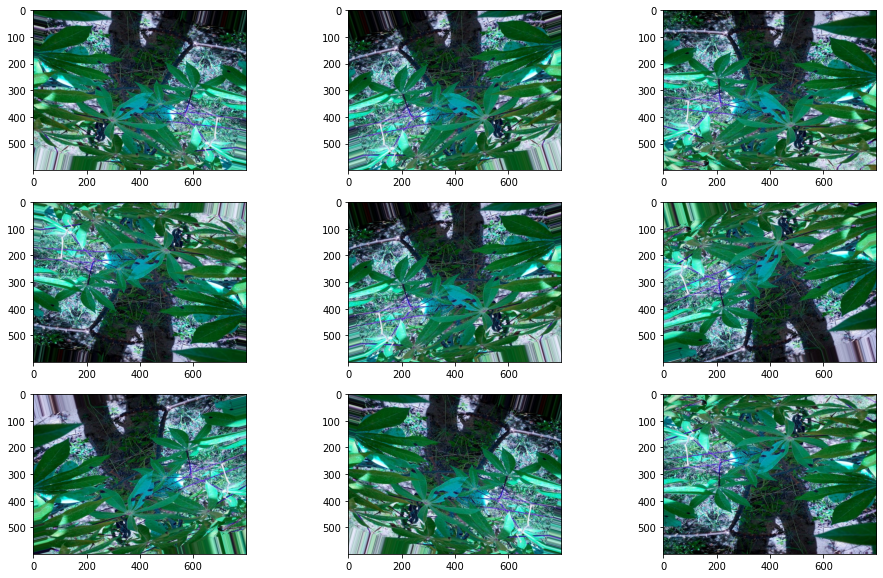

In [ ]:
sample_img =cv2.imread('train_images/1000015157.jpg')
sample_img = np.expand_dims(sample_img,axis=0)
sample_data_gen = ImageDataGenerator(horizontal_flip = True,vertical_flip=True,rotation_range=20)
it = sample_data_gen.flow(sample_img, batch_size=1)
figure = plt.figure(figsize=(16,10))
for i in range(9):
    # define subplot
    plt.subplot(3 ,3,1 + i)
    # generate batch of images
    batch = it.next()
    # convert to unsigned integers for viewing
    image = batch[0].astype('uint8')
    # plot raw pixel data
    plt.imshow(image)
plt.show()

In [ ]:
datagen = ImageDataGenerator(rescale=1./255,validation_split=0.2,horizontal_flip=True,vertical_flip=True) 

train_generator=datagen.flow_from_dataframe(dataframe=train,directory="./train_images/",x_col="image_id",y_col="label",subset="training",
                                            batch_size=32,class_mode="categorical",target_size=(512,512))

validation_generator=datagen.flow_from_dataframe(dataframe=train,directory="./train_images/",x_col="image_id",y_col="label",subset="validation",
                                            batch_size=32,class_mode="categorical",target_size=(512,512))

Found 17118 validated image filenames belonging to 5 classes.
Found 4279 validated image filenames belonging to 5 classes.


In [ ]:
input = Input(shape=(512,512,3,),name='Input_layer1')
conv1 = Conv2D(64,(3,3),activation='relu',strides = (1,1),name = 'conv_layer1')(input)
pool1 = MaxPooling2D(name='pool_layer1')(conv1)
bn1 = BatchNormalization()(pool1)
dp1 = Dropout(0.3)(bn1)

conv2 = Conv2D(128,(3,3),activation='relu',name='conv_layer2')(dp1)
conv22 = Conv2D(128,(3,3),activation='relu',name='conv_layer22')(conv2)
pool2 = MaxPooling2D(name='pool_layer2')(conv22)
bn2 = BatchNormalization()(pool2)
dp2 = Dropout(0.3)(bn2)

conv3 = Conv2D(256,(3,3),activation='relu',name='conv_layer3')(dp2)
conv32 = Conv2D(256,(3,3),activation='relu',name='conv_layer32')(conv3)
pool3 = MaxPooling2D(name='pool_layer3')(conv32)
bn3 = BatchNormalization()(pool3)
dp3 = Dropout(0.3)(bn3)

conv4 = Conv2D(128,(3,3),activation='relu',name='conv_layer4')(dp3)
conv42 = Conv2D(128,(3,3),activation='relu',name='conv_layer42')(conv4)
pool4 = MaxPooling2D(name='pool_layer4')(conv42)
bn4 = BatchNormalization()(pool4)
dp4 = Dropout(0.3)(bn4)

conv5 = Conv2D(64,(3,3),activation='relu',name='conv_layer5')(dp4)
conv52 = Conv2D(64,(3,3),activation='relu',name='conv_layer52')(conv5)
pool5 = MaxPooling2D(name='pool_layer5')(conv52)
bn5 = BatchNormalization()(pool5)
dp5 = Dropout(0.3)(bn5)

conv6 = Conv2D(32,(3,3),activation='relu',name='conv_layer6')(dp5)
conv62 = Conv2D(32,(3,3),activation='relu',name='conv_layer62')(conv6)
pool6 = MaxPooling2D(name='pool_layer6')(conv62)
bn6 = BatchNormalization()(pool6)


flat = Flatten(name='Flatten')(bn6)
dropout = Dropout(rate=0.2)(flat)
dense1 = Dense(128,name='dense_layer1')(dropout)
bn5 = BatchNormalization()(dense1)
dense2 = Dense(32,name='dense_layer2')(bn5)
bn6 = BatchNormalization()(dense2)
output = Dense(5,name='output_layer',activation='softmax')(bn6)

In [ ]:
model = Model(inputs = input, outputs = output)
model.compile(loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1) ,optimizer=tf.keras.optimizers.Adam(),metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_layer1 (InputLayer)    [(None, 512, 512, 3)]     0         
_________________________________________________________________
conv_layer1 (Conv2D)         (None, 510, 510, 64)      1792      
_________________________________________________________________
pool_layer1 (MaxPooling2D)   (None, 255, 255, 64)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 255, 255, 64)      256       
_________________________________________________________________
dropout (Dropout)            (None, 255, 255, 64)      0         
_________________________________________________________________
conv_layer2 (Conv2D)         (None, 253, 253, 128)     73856     
_________________________________________________________________
conv_layer22 (Conv2D)        (None, 251, 251, 128)     147584

In [ ]:
history = model.fit(train_generator,validation_data=validation_generator,batch_size=32,epochs=30)

##Pre-Trained Models Code

In [ ]:
eff = EfficientNetB0(include_top=False,classes=5, input_shape=(512,512,3), weights = 'imagenet', pooling = 'avg')
for layer in eff.layers:
    layer.trainable = True
output = Dense(5, activation = 'softmax', kernel_initializer='glorot_normal')(eff.output)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.3,  
                              patience = 2, 
                              mode = 'min', verbose = 1)
early_stop = EarlyStopping(patience = 4, mode = 'max', monitor='val_accuracy', restore_best_weights=True)

model = Model(vgg.input, output)
model.compile(loss = 'categorical_crossentropy', optimizer = keras.optimizers.Adam(learning_rate = 0.01), metrics = 'accuracy')
history = model.fit(train_generator,validation_data=validation_generator,batch_size=32,epochs=30)